In [1]:
import json
import re 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from collections import Counter, defaultdict
from scipy import stats

from calibration_metric.vis.calibration_plot import plot_df
from calibration_metric.metric import ECEMetric

plt.rcParams["font.family"] = "Nimbus Roman"

from calibration_utils import (read_nucleus_file, 
                                read_gold_file,get_probs_and_accs, 
                                read_benchclamp_file, 
                                get_probs_and_accs_benchclamp,
                                get_probs_and_accs_sql,
                                get_accs_sql)

/brtx/601-nvme1/estengel/miniconda3/envs/bclamp2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


bart_data = read_benchclamp_file("/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-large_spider_past_none_db_val_all_0.0001_5000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T031316.jsonl")
# bart_min_probs, bart_mean_probs, bart_accs = get_probs_and_accs_benchclamp(bart_data) 
spider_gold_path = "/brtx/601-nvme1/estengel/resources/data/benchclamp/processed/Spider/test_all.jsonl"
bart_min_probs, bart_mean_probs, bart_exact_accs = get_probs_and_accs_benchclamp(bart_data) # , spider_gold_path) 

t5_data = read_benchclamp_file("/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-base-lm-adapt_spider_past_none_db_val_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230206T093954.jsonl") 
# t5_min_probs, t5_mean_probs, t5_accs = get_probs_and_accs_benchclamp(t5_data)
t5_min_probs, t5_mean_probs, t5_exact_accs = get_probs_and_accs_benchclamp(t5_data) #, spider_gold_path)

In [3]:
bart_at_k = {}
t5_at_k = {}
for k in range(1, 6):
    __, __, k_bart_exact_accs = get_probs_and_accs_benchclamp(bart_data, k=k) # , spider_gold_path) 
    bart_at_k[k] = k_bart_exact_accs
    __, __, k_t5_exact_accs = get_probs_and_accs_benchclamp(t5_data, k=k) # , spider_gold_path) 
    t5_at_k[k] = k_t5_exact_accs

In [4]:

from matplotlib.lines import Line2D
plt.rcParams["font.family"] = "Nimbus Roman"

SIZE = 100
def horizontal_plot_at_k(min_probs, accs_at_k, path, bclamp_data, gold_path, n_bins = 10, binning_strategy='uniform', title=None, ax = None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4.5,4.5), sharex=True, sharey=True)


    ece_metric = ECEMetric(n_bins=n_bins, binning_strategy=binning_strategy)
    bins_vals_at_k = {}

    markers = ['X', 'o', 's', '^', 'P', 'p']
    colors = ["#212E52", "#444E7E", "#8087AA", "#FEB424", "#FD8700", "#D8511D"]

    for k in accs_at_k.keys():
        if binning_strategy == "uniform":
            (min_values_em, 
            min_bins, 
            min_bin_number) = ece_metric.uniform_bin(min_probs, accs_at_k[k])
        else:
            (min_values_em, 
            min_bins, 
            min_bin_number_sorted,
            min_bin_number) = ece_metric.adaptive_bin(min_probs, accs_at_k[k])
        bins_vals_at_k[k] = (min_values_em, min_bins, min_bin_number)

        if k == 1: 
            # convert exact match accuracy to evaluation accuracy
            print(f"getting sql execution accuracy for each bin")
            min_execution_accs = get_accs_sql(bclamp_data, gold_path, min_bin_number, min_bins) 
            print(f"replacing exact match accuracy with execution accuracy...")

            min_values_ev = [min_execution_accs[bin] for bin in range(len(min_values_em))]


            lines_to_plot = []
            for before_x, before_y, after_x in zip(min_values_em, min_bins, min_values_ev):
                # assert(before_x <= after_x)
                print(f"{before_x:.3f} at {before_y} -> {after_x:.3f}")
                lines_to_plot.append(((before_x, before_y), (after_x, before_y)))
            # replace the accuracies with copies of the average for computing the ECE on the eval match accuracy
            min_df_to_plot_ev = ece_metric.bins_to_df(min_values_ev, min_bins, min_bin_number)
            min_df_to_plot_ev['size_override'] = SIZE
            # overlay onto same plot
            plot = plot_df(min_df_to_plot_ev, 
                        ylabel="Model Prob.", 
                        xlabel=None, 
                        ax = ax, 
                        show_legend=False, 
                        marker = markers[-1],
                        color = colors[-1],
                        size_key='size_override')

        min_df_to_plot_em = ece_metric.bins_to_df(min_values_em, min_bins, min_bin_number)
        min_df_to_plot_em['size_override'] = SIZE

        metric_kwargs = {"x": 0.000, "y": 0.9, "fontsize": 10, "horizontalalignment": "left"}

        # ax.set_title("Min. Prob.", fontsize=10)
        # ax.set_title("Mean Prob.", fontsize=10)
        plot = plot_df(min_df_to_plot_em, 
                    ylabel="Model Prob.", 
                    xlabel=None, 
                    ax = ax, 
                    show_legend=False,
                    marker = markers[k-1],
                    color = colors[k-1],
                    size_key='size_override')
    ax.set_xlabel("Accuracy", fontsize=10) # , bbox = {"xy": (0.7,0.0)})

    # plot connecting lines
    for line in lines_to_plot:
        (x1, y1), (x2, y2) = line
        ax.plot([x1, x2], [y1, y2], color='black', linewidth=0.5, linestyle='--')

    # handles, labels = plt.gca().get_legend_handles_labels()
    # fig.legend(handles, labels, fontsize=8, ncol=2, title="Log Count", frameon=False, bbox_to_anchor=(0.53, 0.71), handletextpad=0.1, columnspacing=0.1)

    labels = ['Acc@1', 'Acc@2', 'Acc@3', 'Acc@4', 'Acc@5', 'Exec.']
    handles = []
    for m, c, l in zip(markers, colors, labels):
        handles.append(Line2D([0], [0], marker=m, color='w', label=l, markerfacecolor=c, markersize=8)) 

    ax.legend(handles, labels, frameon=False, ncol=3)
    

    if title is not None:
        ax.set_title(title, fontsize=14)

    if path is not None:
        plt.savefig(path, bbox_inches='tight')
    # return min_values, min_bins, min_bin_number



getting sql execution accuracy for each bin
Bin number: 0 with confidence 0.9927319366507277
command: python3 evaluation.py --gold /brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/analysis_spider_0/gold.txt --pred /brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/analysis_spider_0/pred.txt --db /brtx/601-nvme1/estengel/resources/data/benchclamp/raw/test_sql/database --table /brtx/601-nvme1/estengel/resources/data/benchclamp/raw/Spider/tables.json --etype all
stdout: medium pred: SELECT max ( capacity ) , avg ( average ) FROM stadium
medium gold: SELECT max ( capacity ) , average FROM stadium

extra pred: SELECT model FROM cars_data WHERE weight < ( SELECT avg ( weight ) FROM cars_data )
extra gold: SELECT T1.model FROM car_names AS T1 JOIN cars_data AS T2 ON T1.makeid = T2.id WHERE T2.weight < ( SELECT avg ( weight ) FROM cars_data )

extra pred: SELECT model FROM cars_data WHERE weight < ( SELECT avg ( weight ) FROM cars_data )
extra gold: SELECT T1.mode

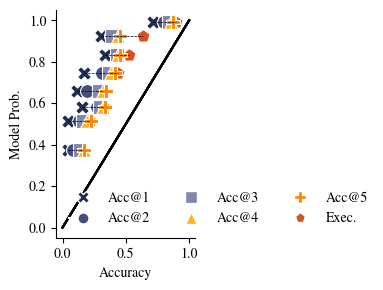

In [5]:
# horizontal_plot(bart_min_probs, 
#                 bart_exact_accs, 
#                 None, 
#                 bclamp_data=bart_data,
#                 gold_path=spider_gold_path,
#                 n_bins=10, 
#                 title="Acc@1",
#                 binning_strategy='adaptive')

# t5_at_k[1] = t5_exact_accs
# for k in range(2, 6):
fig, ax = plt.subplots(1,1, figsize=(3,3), sharex=True, sharey=True)
horizontal_plot_at_k(t5_min_probs, 
                t5_at_k, 
                None, 
                bclamp_data=t5_data,
                gold_path=spider_gold_path,
                n_bins=10, 
                ax = ax,
                # title=f"Acc@{k}",
                binning_strategy='adaptive')

plt.tight_layout()
plt.savefig("/home/estengel/papers/calibration-parsing-2023/figures/exec_vs_em.pdf", bbox_inches="tight")


In [6]:
exact_bart_values, exact_bart_bins, exact_bart_bin_number = single_plot(bart_min_probs, 
                                                          bart_exact_accs, 
                                                          None, 
                                                          use_exact_match=True,
                                                          bclamp_data=bart_data,
                                                          gold_path=spider_gold_path,
                                                          n_bins=10, 
                                                          binning_strategy='adaptive')

eval_bart_values, eval_bart_bins, eval_bart_bin_number = single_plot(bart_min_probs, 
                                                          bart_exact_accs, 
                                                          None, 
                                                          use_exact_match=False,
                                                          bclamp_data=bart_data,
                                                          gold_path=spider_gold_path,
                                                          n_bins=10, 
                                                          binning_strategy='adaptive')

NameError: name 'single_plot' is not defined

In [ ]:

# TODO (elias): how can the execution accuracy be lower than the exact match accuracy?
t5_values, t5_bins, t5_bin_number = comparison_plot(t5_min_probs, 
                                                    t5_mean_probs, 
                                                    t5_exact_accs, 
                                                    None, 
                                                    use_exact_match=True,
                                                    bclamp_data=t5_data,
                                                    gold_path=spider_gold_path,
                                                    n_bins=10, 
                                                    binning_strategy='adaptive')

t5_values, t5_bins, t5_bin_number = comparison_plot(t5_min_probs, 
                                                    t5_mean_probs, 
                                                    t5_exact_accs, 
                                                    None, 
                                                    use_exact_match=False,
                                                    bclamp_data=t5_data,
                                                    gold_path=spider_gold_path,
                                                    n_bins=10, 
                                                    binning_strategy='adaptive')